<a href="https://colab.research.google.com/github/osommersell264/code/blob/master/OpenSourceAPIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Using Open Source APIs
## Prepared by Martha Norrick, Mayor's Office of Data Analytics, mnorrick@cityhall.nyc.gov

### What We'll Cover

There is a ton of open source data available on the internet.  This session will go through three commonly used APIs for City data scientists, the US Census and American Community Survey API, the Open Data API, and DoITT's Geoclient geocoding API.

I'm assuming if you're in this session, you already know at least a little bit about using Python for data science, including importing packages, loading and handling Pandas dataframes, and basic SQL like queries.  If I'm moving too fast, holler and I can slow down!  But there's a lot to cover so let's get started.

### What's an API?

First off, I'm not a computer scientist.  But API stands for Application Programming Interface, which is basically how computers or computer programs can communicate with each other.  For our purposes, we're writing a computer program to interact with a database application and ask it nicely to send us back data.  For a more nuanced understanding of APIs, ask your friendly neighborhood computer scientist or engineer!

Most APIs require you to authenticate, e.g. tell the application who you are, in order to access the data or application.  Usually that takes the form of an API key.  It's important to keep your API keys private--if you publish them on the internet, they may end up being misused by others or subject you to rate limits or if it's an API that charges per call, you can end up with a very nasty surprise.  We'll talk about setting environment variables or reading in our credentials from a local file so as to protect our API keys!

## The American Community Survey and Census APIs

Hopefully needing no introduction, the US Census and the American Community Survey are some of the most valuable data we have about NYC and the people and businesses here.  Many of you may have downloaded data from American Factfinder or the census FTP site.  

The upside of using the API is that it can save some time clicking on stuff, and also make it easier to share replicable analysis with others without having to also share data files.  The downside is that not every single piece of data is available via the API, and it can be easy to pull data without really understanding it.  

I *highly* encourage you to reach out to some of the many knowledgable folks in the City if you have questions about which variables are appropriate, whether the results are reliable at the level of geography you're looking at, etc.  DCP has several excellent tools for this as does the Poverty Research Unit at the Mayor's Office for Economic Opportunity.  The Census also has great documentation!  And there's an active Slack group for API users that you can join.

With that, let's get started by importing the packages we'll need.

In [ ]:
!pip install geopandas
!pip install fiona
!pip install usaddress
import pandas as pd
import requests
import os
import urllib
import json
import numpy as np
import io
from io import BytesIO
from functools import reduce
import geopandas as gpd
import fiona
import usaddress
import matplotlib.pyplot as plt

In most cases, we use the 5-year ACS estimates, which generally have the lowest margin of error of the all the different ACS options, but also aggregates the most years together.  The documentation and links are available here https://www.census.gov/data/developers/data-sets/acs-5year.htm.  

From the census: The 5-year estimates from the ACS are "period" estimates that represent data collected over a period of time. The primary advantage of using multiyear estimates is the increased statistical reliability of the data for less populated areas and small population subgroups.

You do need to request a key for this data here: https://api.census.gov/data/key_signup.html but it's fast.

One way to handle keys in Python is through environment variables.  Environment variables are similar to Python variables, except instead of explictly writing the value into the program, we explictly write the value in a file called an environment file (.env) that our program will look to to find the value of the key.

In [3]:
#package to handle environment variables in colab
!pip install colab-env -qU
import colab_env

KeyboardInterrupt: ignored

In [ ]:
from dotenv import load_dotenv
load_dotenv()
myAPI = os.getenv("CENSUS_API")
subscription_key = os.getenv("GEO_SUB_KEY")


Let's take a quick look at the [Census API website](https://www.census.gov/data/developers/data-sets.html)!  We're going to focus on the American Community Survey 5 year tables but as you can see, there are lots of different data products available via API, and once you've got the general structure down, it's pretty easy to adapt to the structure you need.  Variables for the detailed tables are available [here](https://api.census.gov/data/2019/acs/acs5/variables.html).  Example calls for geographies are [here](https://api.census.gov/data/2019/acs/acs5/examples.html).  Let's look at ZCTA and PUMA below.

As you can see, there are a LOT of different features we can pull and at many different geography levels.  One thing we can do to make it a little easier is to read the variables into our program and filter down to the group we're interested in.

In [ ]:
#read variables
acs_vars = pd.read_json('https://api.census.gov/data/2019/acs/acs5/variables.json')

In [ ]:
acs_vars

,variables
AIANHH,"{'label': 'Geography', 'group': 'N/A', 'limit'..."
AIHHTL,"{'label': 'Geography', 'group': 'N/A', 'limit'..."
AIRES,"{'label': 'Geography', 'group': 'N/A', 'limit'..."
ANRC,"{'label': 'Geography', 'group': 'N/A', 'limit'..."
B01001A_001E,"{'label': 'Estimate!!Total:', 'concept': 'SEX ..."
...,...
UA,"{'label': 'Geography', 'group': 'N/A', 'limit'..."
ZCTA,"{'label': 'Geography', 'group': 'N/A', 'limit'..."
for,"{'label': 'Census API FIPS 'for' clause', 'con..."
in,"{'label': 'Census API FIPS 'in' clause', 'conc..."


In [ ]:
#transform the json into a flatter file.
acs_vars = pd.concat([acs_vars.drop(['variables'], axis=1), acs_vars['variables'].apply(pd.Series)], axis=1).reset_index()

In [ ]:
acs_vars.head(30)

,index,label,group,limit,concept,predicateType,attributes,required,predicateOnly
0,AIANHH,Geography,N/A,0,NaN,NaN,NaN,NaN,NaN
1,AIHHTL,Geography,N/A,0,NaN,NaN,NaN,NaN,NaN
2,AIRES,Geography,N/A,0,NaN,NaN,NaN,NaN,NaN
3,ANRC,Geography,N/A,0,NaN,NaN,NaN,NaN,NaN
4,B01001A_001E,Estimate!!Total:,B01001A,0,SEX BY AGE (WHITE ALONE),int,"B01001A_001EA,B01001A_001M,B01001A_001MA",NaN,NaN
5,B01001A_002E,Estimate!!Total:!!Male:,B01001A,0,SEX BY AGE (WHITE ALONE),int,"B01001A_002EA,B01001A_002M,B01001A_002MA",NaN,NaN
6,B01001A_003E,Estimate!!Total:!!Male:!!Under 5 years,B01001A,0,SEX BY AGE (WHITE ALONE),int,"B01001A_003EA,B01001A_003M,B01001A_003MA",NaN,NaN
7,B01001A_004E,Estimate!!Total:!!Male:!!5 to 9 years,B01001A,0,SEX BY AGE (WHITE ALONE),int,"B01001A_004EA,B01001A_004M,B01001A_004MA",NaN,NaN
8,B01001A_005E,Estimate!!Total:!!Male:!!10 to 14 years,B01001A,0,SEX BY AGE (WHITE ALONE),int,"B01001A_005EA,B01001A_005M,B01001A_005MA",NaN,NaN
9,B01001A_006E,Estimate!!Total:!!Male:!!15 to 17 years,B01001A,0,SEX BY AGE (WHITE ALONE),int,"B01001A_006EA,B01001A_006M,B01001A_006MA",NaN,NaN


In [ ]:
school = acs_vars[acs_vars.group == 'B14003'][['index', 'label']]

In [ ]:
pd.set_option('max_colwidth', 400)
school

,index,label
7710,B14003_001E,Estimate!!Total:
7711,B14003_002E,Estimate!!Total:!!Male:
7712,B14003_003E,Estimate!!Total:!!Male:!!Enrolled in public school:
7713,B14003_004E,Estimate!!Total:!!Male:!!Enrolled in public school:!!3 and 4 years
7714,B14003_005E,Estimate!!Total:!!Male:!!Enrolled in public school:!!5 to 9 years
7715,B14003_006E,Estimate!!Total:!!Male:!!Enrolled in public school:!!10 to 14 years
7716,B14003_007E,Estimate!!Total:!!Male:!!Enrolled in public school:!!15 to 17 years
7717,B14003_008E,Estimate!!Total:!!Male:!!Enrolled in public school:!!18 and 19 years
7718,B14003_009E,Estimate!!Total:!!Male:!!Enrolled in public school:!!20 to 24 years
7719,B14003_010E,Estimate!!Total:!!Male:!!Enrolled in public school:!!25 to 34 years


In [ ]:
#swap the variable key you're interested in.
detail_key = 'B14003_022E'
detail_name = 'BOYS_3_4_NOT_ENROLLED'

In [ ]:
#by zcta

url = "https://api.census.gov/data/2019/acs/acs5?get=NAME," + detail_key +\
  "&for=zip%20code%20tabulation%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
key_zip = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
key_zip = key_zip.rename(columns={detail_key:detail_name+'_2019', 'zip code tabulation area':'zip'})

In [ ]:
key_zip.head()

,NAME,BOYS_3_4_NOT_ENROLLED_2019,state,zip,Unnamed: 4
0,ZCTA5 11804,34,36,11804,NaN
1,ZCTA5 11930,0,36,11930,NaN
2,ZCTA5 11941,20,36,11941,NaN
3,ZCTA5 11962,0,36,11962,NaN
4,ZCTA5 11702,15,36,11702,NaN


In [ ]:
key_zip.drop(columns='Unnamed: 4', inplace=True)

In [ ]:
key_zip.head()

,NAME,BOYS_3_4_NOT_ENROLLED_2019,state,zip
0,ZCTA5 11804,34,36,11804
1,ZCTA5 11930,0,36,11930
2,ZCTA5 11941,20,36,11941
3,ZCTA5 11962,0,36,11962
4,ZCTA5 11702,15,36,11702


In [ ]:
key_zip.dtypes

NAME                          object
BOYS_3_4_NOT_ENROLLED_2019     int64
state                          int64
zip                            int64
dtype: object

In [ ]:
key_zip.zip = key_zip.zip.astype(str)

In [ ]:
#narrow to NYC ZCTAs
#read in NYC ZCTAs from Open Data as shapefile using Geopandas

In [ ]:
nyc_zcta = gpd.read_file('https://data.cityofnewyork.us/resource/pri4-ifjk.geojson')

In [ ]:
nyc_zcta.dtypes

modzcta       object
label         object
zcta          object
pop_est       object
geometry    geometry
dtype: object

In [ ]:
boys_3_4_not_enrolled_nyc_zcta = pd.merge(left=nyc_zcta, right=key_zip, left_on='modzcta', right_on='zip' ,how='inner')

In [ ]:
boys_3_4_not_enrolled_nyc_zcta.head()

,modzcta,label,zcta,pop_est,geometry,NAME,BOYS_3_4_NOT_ENROLLED_2019,state,zip
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 40.74345, -73.98901 40.74380, -73.98887 40.74453, -73.99097 40.74542, -73.99142 40.74480, -73.99187 40.74419, -73.99207 40.74392, -73.99494 40.74506, -73.99760 40.74620, -73.99783 40.74588, -73.99801 40.74595, -73.99755 40.74658, -73.99887 40.74713, -74.00040 40.74777, -74.00085 40.74715, -74.00369 40.74836, -74.00424 40.74859, -74.00653 40.74956, ...",ZCTA5 10001,0,36,10001
1,10002,10002,10002,74993,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 40.71462, -73.99680 40.71504, -73.99653 40.71549, -73.99623 40.71600, -73.99615 40.71609, -73.99606 40.71623, -73.99581 40.71665, -73.99543 40.71728, -73.99481 40.71846, -73.99440 40.71946, -73.99411 40.72015, -73.99407 40.72024, -73.99404 40.72032, -73.99402 40.72038, -73.99379 40.72094, -73.99353 40.72164, -73.99336 40.72208, -73.99334 40.72214, ...",ZCTA5 10002,87,36,10002
2,10003,10003,10003,54682,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 40.72297, -73.98939 40.72317, -73.99027 40.72343, -73.99102 40.72365, -73.99128 40.72373, -73.99136 40.72375, -73.99220 40.72401, -73.99253 40.72412, -73.99260 40.72414, -73.99258 40.72420, -73.99233 40.72491, -73.99221 40.72523, -73.99206 40.72564, -73.99180 40.72639, -73.99186 40.72642, -73.99364 40.72729, -73.99314 40.72787, -73.99426 40.72841, ...",ZCTA5 10003,10,36,10003
3,10026,10026,10026,39363,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 40.80471, -73.96032 40.80399, -73.96248 40.80488, -73.96201 40.80551)), ((-73.95862 40.79997, -73.96007 40.80058, -73.95965 40.80116, -73.95915 40.80184, -73.95869 40.80247, -73.95825 40.80311, -73.95820 40.80389, -73.95824 40.80440, -73.95824 40.80453, -73.95826 40.80471, -73.95827 40.80483, -73.95827 40.80494, -73.95828 40.80505, -73.95827 40.805...",ZCTA5 10026,147,36,10026
4,10004,10004,10004,3028,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 40.70861, -74.00889 40.70904, -74.00801 40.70798, -74.00827 40.70772)), ((-74.01580 40.70135, -74.01579 40.70154, -74.01575 40.70191, -74.01574 40.70199, -74.01583 40.70209, -74.01630 40.70269, -74.01653 40.70326, -74.01663 40.70373, -74.01665 40.70389, -74.01666 40.70408, -74.01670 40.70463, -74.01668 40.70474, -74.01668 40.70480, -74.01676 40.704...",ZCTA5 10004,0,36,10004


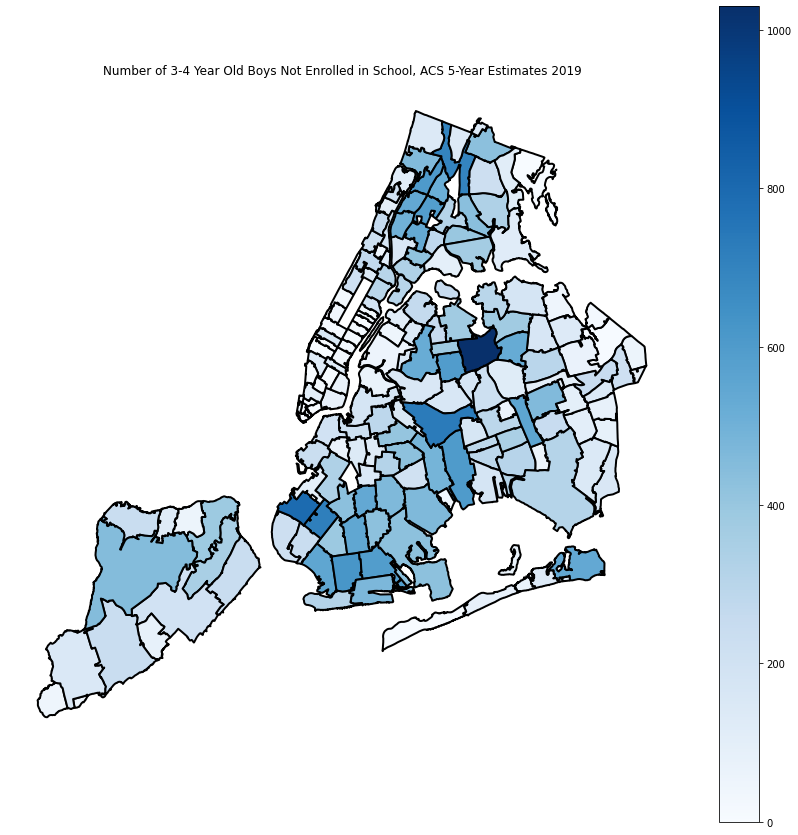

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Number of 3-4 Year Old Boys Not Enrolled in School, ACS 5-Year Estimates 2019")
boys_3_4_not_enrolled_nyc_zcta.plot(ax=ax, cmap='Blues', column='BOYS_3_4_NOT_ENROLLED_2019', edgecolor='black', lw=2, legend=True)
plt.show();

In [ ]:
#run this cell if you want to export the file
from google.colab import files
key_zip.to_csv(detail_name + '2019_by_zip.csv') 
files.download(detail_name + '2019_by_zip.csv')

In [ ]:
#by PUMA

url = "https://api.census.gov/data/2019/acs/acs5?get=NAME," + detail_key +\
  "&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
key_puma = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
key_puma = key_puma.rename(columns={detail_key:detail_name+'_2019', 'public use microdata area':'puma'})

In [ ]:
key_puma.head()

,NAME,BOYS_3_4_NOT_ENROLLED_2019,state,puma,Unnamed: 4
0,"NYC-Manhattan Community District 3--Chinatown & Lower East Side PUMA, New York",162,36,3809,NaN
1,"NYC-Manhattan Community District 11--East Harlem PUMA, New York",700,36,3804,NaN
2,"NYC-Manhattan Community District 6--Murray Hill, Gramercy & Stuyvesant Town PUMA; New York",200,36,3808,NaN
3,"NYC-Staten Island Community District 3--Tottenville, Great Kills & Annadale PUMA; New York",634,36,3901,NaN
4,"NYC-Staten Island Community District 2--New Springville & South Beach PUMA, New York",749,36,3902,NaN


### Open Data API

A personal favorite, if you work with Open Data and find yourself downloading data frequently, there's an easier way!  Let's go look at Open Data!

Every Open Data set has an ID that you can reference to pull the Open Data set directly.  You can even filter or use SQL-like queries to target just the data you need instead of having to pull an entire large dataset and load it into memory.

In [ ]:
#we snag the URL from the Open Data Website, as a CSV or a JSON!
dog_licenses_url = 'https://data.cityofnewyork.us/resource/nu7n-tubp.csv'

In [ ]:
dog_licenses = pd.read_csv(dog_licenses_url)

In [ ]:
dog_licenses.shape

(1000, 11)

We know there are more than 1,000 licensed dogs in NYC!  What gives?

The API automatically limits the call to 1,000 rows unless we specify otherwise.  Let's up the limit in the URL!  In the current version of the API, there's no limit to how many rows you can pull at once.  However, it can be quicker to page through the data if you're pulling a huge amount at once.  See the API documentation for more info!

In [ ]:
dog_licenses_url = 'https://data.cityofnewyork.us/resource/nu7n-tubp.csv?$limit=5000'

In [ ]:
dog_licenses = pd.read_csv(dog_licenses_url)

In [ ]:
dog_licenses.shape

(5000, 11)

Let's say we just want to examine the phenomenon of the Labradoodle.

In [ ]:
#filter rows to where Breed Name = Labradoodle
dog_licenses_url = 'https://data.cityofnewyork.us/resource/nu7n-tubp.csv?$limit=500000&breedname=Labradoodle'

In [ ]:
dog_licenses = pd.read_csv(dog_licenses_url)

In [ ]:
dog_licenses.head()

,rownumber,animalname,animalgender,animalbirth,breedname,borough,zipcode,licenseissueddate,licenseexpireddate,extract_year,unique_dog_id
0,97,BOO,F,2013,Labradoodle,NaN,11211,2014-09-17T00:00:00.000,2019-09-17T00:00:00.000,2016.0,NaN
1,139,ZOEY,F,2014,Labradoodle,NaN,10301,2014-09-20T00:00:00.000,2019-09-20T00:00:00.000,2016.0,NaN
2,140,ROSIE,F,2013,Labradoodle,NaN,10013,2014-09-20T00:00:00.000,2019-09-20T00:00:00.000,2016.0,NaN
3,277,ALISTAIR,M,2012,Labradoodle,NaN,10011,2014-10-04T00:00:00.000,2016-10-04T00:00:00.000,2016.0,NaN
4,339,MURPHY,M,2012,Labradoodle,NaN,10016,2014-10-09T00:00:00.000,2019-07-18T00:00:00.000,2016.0,NaN


In [ ]:
dog_licenses.shape

(3685, 11)

In [ ]:
dog_licenses.groupby('animalname')['rownumber'].count().reset_index().sort_values('rownumber', ascending=False).head(20)

,animalname,rownumber
462,LUCY,66
794,TEDDY,51
194,COOPER,49
156,CHARLIE,41
692,RUBY,39
685,ROSIE,38
47,BAILEY,36
476,MAGGIE,34
501,MAX,32
770,STELLA,29


We can also do more complicated queries!

In [ ]:
#show me the columns breedname, animal name, and zip code where the animal gender is Female
dog_licenses_url = "https://data.cityofnewyork.us/resource/nu7n-tubp.csv?$limit=500000&$select=breedname,animalname,zipcode&$where=animalgender='F'"

In [ ]:
dog_licenses = pd.read_csv(dog_licenses_url)

In [ ]:
dog_licenses.head()

,breedname,animalname,zipcode
0,American Pit Bull Mix / Pit Bull Mix,PAIGE,10035
1,Akita Crossbreed,QUEEN,10013
2,Maltese,LOLA,10028
3,Labrador Retriever Crossbreed,CHEWBACCA,10013
4,Dachshund Smooth Coat,HEIDI-BO,11215


### Geoclient API

The Geoclient API is handy for geocoding reasonable numbers of addresses--if you're doing hundreds of thousands, you should get in touch with the DoITT team and they can walk you through installing Geosupport on your local machine so you don't have to send API calls and it goes a lot quicker.  But if you have a smaller number of addresses to handle, the Geoclient API is quite handy!  You will need a subscription key, which is available [here](https://api-portal.nyc.gov/).

A frequently needed step is to clean up your addresses!  I've found the package USAddress to be super useful here in separating addresses into their component parts which makes the geocoder extra happy.  You can just dump a whole address in raw as well, but results vary.  We could do hours on different geocoding options, trade-offs, nuance!  I am going to breeze through this but I highly recommend reading the documentation and understanding what you're getting back--is it the front door?  Is it the top of the center of the house?  Sometimes that matters!

In [ ]:
#the USAddress package is awesome, and can parse gross addresses into their component parts
parser = lambda x: usaddress.tag(x, tag_mapping={'Recipient': 'recipient',
   'AddressNumber': 'street_number',
   'AddressNumberPrefix': 'street_number',
   'AddressNumberSuffix': 'street_number',
   'StreetName': 'street_name',
   'StreetNamePreDirectional': 'street_name',
   'StreetNamePreModifier': 'street_name',
   'StreetNamePreType': 'street_name',
   'StreetNamePostDirectional': 'street_name',
   'StreetNamePostModifier': 'street_name',
   'StreetNamePostType': 'street_name',
   'CornerOf': 'street_corner',
   'IntersectionSeparator': 'street_intsep',
   'LandmarkName': 'street_landmark',
   'USPSBoxGroupID': 'po_box',
   'USPSBoxGroupType': 'po_box',
   'USPSBoxID': 'po_box',
   'USPSBoxType': 'po_box',
   'BuildingName': 'unit',
   'OccupancyType': 'unit',
   'OccupancyIdentifier': 'unit',
   'SubaddressIdentifier': 'unit',
   'SubaddressType': 'unit',
   'PlaceName': 'city',
   'StateName': 'state',
   'ZipCode': 'zip_code',
})

In [ ]:
#two different functions for calling geoclient: one for having street number and street name, and another for intersections
#credit for this code to Adam Santos of NYC Opportunity!

def geocode(row, street_num_col, street_name_col, borough_col):
    try:
        house_num = row[street_num_col]
        street = row[street_name_col]
        borough = str(row[borough_col])
        url= '''https://api.nyc.gov/geo/geoclient/v1/address.json?houseNumber={}&street={}&borough={}&subscription-key={}'''.format(house_num,street,borough,subscription_key)
        print(url)
        response = requests.get(url)
        js = response.json()
        return js['address']
        print(js['address'])
    except:
        return 'No Geocode'
    
def geocode_intersection(row, intersect1, intersect2, borough_col):
    try:
        crossStreetOne = row[intersect1]
        crossStreetTwo = row[intersect2]
        borough = str(row[borough_col])
        url= '''https://api.nyc.gov/geo/geoclient/v1/address.json?crossStreetOne={}&crossStreetTwo={}&borough={}&subscription-key={}'''.format(crossStreetOne,crossStreetTwo,borough,subscription_key)
        print(url)
        response = requests.get(url)
        js = response.json()
        return js['intersection']
    except:
        return 'No Geocode'

In [ ]:
#let's import some addresses!

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving example_address_data.csv to example_address_data (1).csv


In [ ]:
import io
addresses = pd.read_csv(io.BytesIO(uploaded['example_address_data.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#let's take a look at the data!  We've got some units and stuff up in these addresses...
addresses.head()

,Address_Full,Address,Borough,City,State/Province,Zip/Postal,Zip4,CountryCode
0,"14207 Quince Ave, Flushing, NY 11355",14207 Quince Ave,Queens,Flushing,NY,11355,3563.0,US
1,"1760 Bussing Ave, Bronx, NY 10466",1760 Bussing Ave,Bronx,Bronx,NY,10466,2048.0,US
2,"19 Alabama Ave Fl 2, Brooklyn, NY 11207",19 Alabama Ave Fl 2,Brooklyn,Brooklyn,NY,11207,2303.0,US
3,"300 Putnam Ave Apt 6B, Brooklyn, NY 11216",300 Putnam Ave Apt 6B,Brooklyn,Brooklyn,NY,11216,1780.0,US
4,"683 Dean St Apt G2, Brooklyn, NY 11238",683 Dean St Apt G2,Brooklyn,Brooklyn,NY,11238,3262.0,US


In [ ]:
#let's prep our data for parsing by making sure everything is a string and then applying the parser on the column with the address
addresses['Address'] = addresses['Address'].astype(str)
addresses['Parsed'] = addresses['Address'].apply(parser)

#now we've stored the dictionary the parser returns in a column so let's split it out and then get the components we're interested in!
addresses[['street_stuff','type']] = pd.DataFrame(addresses['Parsed'].values.tolist())
addresses['street_number'] = [d.get('street_number') for d in addresses.street_stuff]
addresses['street_name'] = [d.get('street_name') for d in addresses.street_stuff]

In [ ]:
addresses.head()

,Address_Full,Address,Borough,City,State/Province,Zip/Postal,Zip4,CountryCode,Parsed,street_stuff,type,street_number,street_name
0,"14207 Quince Ave, Flushing, NY 11355",14207 Quince Ave,Queens,Flushing,NY,11355,3563.0,US,"({'street_number': '14207', 'street_name': 'Quince Ave'}, Street Address)","{'street_number': '14207', 'street_name': 'Quince Ave'}",Street Address,14207,Quince Ave
1,"1760 Bussing Ave, Bronx, NY 10466",1760 Bussing Ave,Bronx,Bronx,NY,10466,2048.0,US,"({'street_number': '1760', 'street_name': 'Bussing Ave'}, Street Address)","{'street_number': '1760', 'street_name': 'Bussing Ave'}",Street Address,1760,Bussing Ave
2,"19 Alabama Ave Fl 2, Brooklyn, NY 11207",19 Alabama Ave Fl 2,Brooklyn,Brooklyn,NY,11207,2303.0,US,"({'street_number': '19', 'street_name': 'Alabama Ave', 'unit': 'Fl 2'}, Street Address)","{'street_number': '19', 'street_name': 'Alabama Ave', 'unit': 'Fl 2'}",Street Address,19,Alabama Ave
3,"300 Putnam Ave Apt 6B, Brooklyn, NY 11216",300 Putnam Ave Apt 6B,Brooklyn,Brooklyn,NY,11216,1780.0,US,"({'street_number': '300', 'street_name': 'Putnam Ave', 'unit': 'Apt 6B'}, Street Address)","{'street_number': '300', 'street_name': 'Putnam Ave', 'unit': 'Apt 6B'}",Street Address,300,Putnam Ave
4,"683 Dean St Apt G2, Brooklyn, NY 11238",683 Dean St Apt G2,Brooklyn,Brooklyn,NY,11238,3262.0,US,"({'street_number': '683', 'street_name': 'Dean St', 'unit': 'Apt G2'}, Street Address)","{'street_number': '683', 'street_name': 'Dean St', 'unit': 'Apt G2'}",Street Address,683,Dean St


In [ ]:
#now let's make a column that has the geocode return for the address and apply the geocoder to the column!
addresses['geo'] = addresses.apply(lambda x:geocode(x, 'street_number','street_name', 'Borough'), axis=1)

In [ ]:
#let's pull out the latitude and longitude and bbl for each!
addresses['latitude'] = [d.get('latitude') for d in addresses.geo]
addresses['longitude'] = [d.get('longitude') for d in addresses.geo]
addresses['bbl'] = [d.get('bbl') for d in addresses.geo]

In [ ]:
#let's turn our dataframe into a shapefile for mapping!
address_shapes = gpd.GeoDataFrame(addresses, geometry=gpd.points_from_xy(addresses.longitude, addresses.latitude))

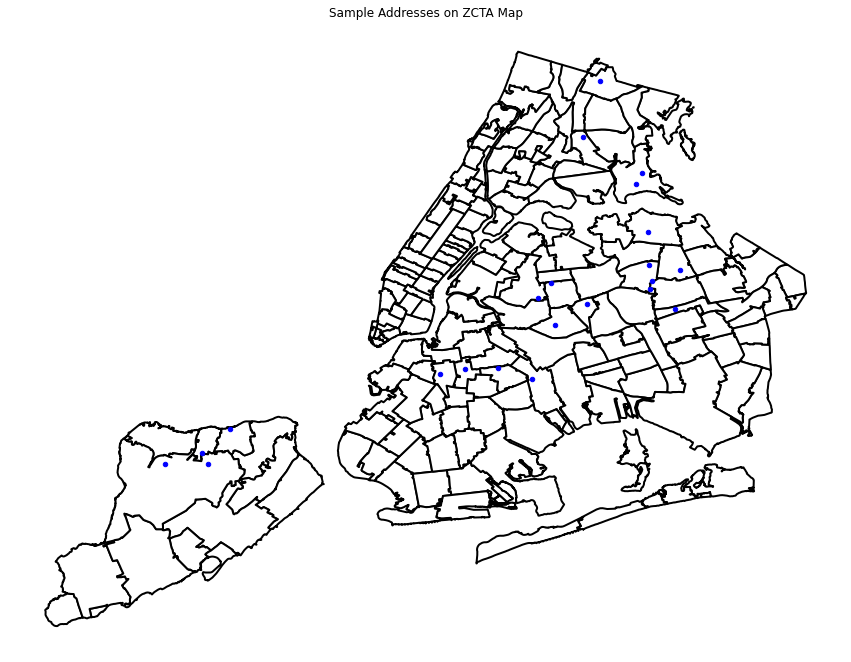

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Sample Addresses on ZCTA Map")
nyc_zcta.plot(ax=ax, edgecolor='black', lw=2, legend=True, facecolor='white')
address_shapes.plot(ax=ax, color='blue', markersize=20)
plt.show();

### Debrief!

There are so many [Open APIs](https://github.com/public-apis/public-apis#government) out there!  Personal favorite: Wegmans has a public API!